## Goal
Understanding the challenges in training neural nets such as :

1. Weight Initialization
2. Adjusting Learning Rates
3. Appropriate use of Normalization
4. Picking the right Activation Functions
5. Understanding the flow of gradients through the network

## Task
Training Autoencoders (AEs) and Variational Autoencoders (VAEs) on the task of efficiently encoding and decoding (reconstructing) images (grayscale) consisting of a white square with side length sampled uniformly and located at some random position in an image that is otherwise just made up of black pixels.

(Task inspired from this [paper](https://arxiv.org/pdf/1606.05579) and explained in this [video](https://www.youtube.com/watch?v=9zKuYvjFFS8))

#### Objectives: 
1. Get the autoencoder to learn latent representations that encode the location (x, y) and size of the square to enable 
efficient reconstruction.
2. Observe how well the model is able to perform when the image size is changes or when the number of parameters and the latent size is reduced/increased
3. Identify reasons for exploding gradients if any ([Autoencoders can quickly explode if we are not careful](https://www.reddit.com/r/MachineLearning/comments/56dy7v/how_to_train_an_autoencoder/))

#### Task Modification:
We can consider applying this task with colored squares as well to encourage encoding the color information as well in the latent representation

In [1]:
import torch
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

## Creating the dataset

In [2]:
# square_size -> (min_size, max_size)

def generate_datapoint(size = (28, 28), square_size = (3, 7), grayscale = True):
    
    assert square_size[0] < size[0] and square_size[0] < size[1]
    assert square_size[1] < size[0] and square_size[1] < size[1]
    
    random_square_size = random.randint(*square_size)
    
    x_pos = random.randint(0, size[1] - random_square_size)
    y_pos = random.randint(0, size[0] - random_square_size)
    
    if grayscale:
        img = np.zeros(size)
        img[x_pos:x_pos + random_square_size, y_pos:y_pos + random_square_size] = 1.0
    else:
        img = np.zeros((3, *size))
        
        img[0,x_pos:x_pos + random_square_size, y_pos:y_pos + random_square_size] = random.random()
        img[1, x_pos:x_pos + random_square_size, y_pos:y_pos + random_square_size] = random.random()
        img[2, x_pos:x_pos + random_square_size, y_pos:y_pos + random_square_size] = random.random()
        
    
    return img, x_pos, y_pos, random_square_size


def generate_dataset(n = 3000, size = (28, 28), square_size = (3, 7), grayscale = True):
    x = []
    y = []
    
    for _ in range(n):
        img, x_pos, y_pos, spot_size = generate_datapoint(size, square_size, grayscale = grayscale)
        x.append(img)
        y.append([x_pos, y_pos, spot_size])
        
    return np.array(x), np.array(y)

## Define Autoencoder Model

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [114]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    
    def __init__(self,
                 s,
                 data_channels = 1,
                 conv_feature_maps = 16,
                 kernel_size = 3,
                 stride_length = 1,
                 pool_size = 2,
                 fc_size = 256,
                 latent_size = 64
                ):
        super(Autoencoder, self).__init__()
        
        self.is_log_mode = False
        
        conv2d_output_size = (s-kernel_size)//stride_length + 1
        pooling_output_size = conv2d_output_size//2
        deconv2d_output_size = (pooling_output_size - 1) * stride_length + kernel_size
        
        print(f"conv2d_output_size : {conv2d_output_size}")
        print(f"pooling_output_size : {pooling_output_size}")
        print(f"flatten_size : {conv_feature_maps * pooling_output_size * pooling_output_size}")
        
        self.encoder = nn.Sequential(
            nn.Conv2d(data_channels, conv_feature_maps, kernel_size, stride = stride_length),
            nn.BatchNorm2d(conv_feature_maps),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(pool_size, pool_size),
            
            nn.Flatten(),
            nn.Linear(conv_feature_maps * pooling_output_size * pooling_output_size, fc_size),
            nn.BatchNorm1d(fc_size),
            nn.LeakyReLU(inplace=True),
            
            nn.Linear(fc_size, latent_size),
            nn.BatchNorm1d(latent_size),
            
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, fc_size),
            nn.BatchNorm1d(fc_size),
            nn.LeakyReLU(inplace=True),

            nn.Linear(fc_size, conv_feature_maps * pooling_output_size * pooling_output_size),
            nn.LeakyReLU(inplace=True),

            nn.Unflatten(1, (conv_feature_maps, pooling_output_size, pooling_output_size)),
            
            nn.ConvTranspose2d(conv_feature_maps, data_channels, kernel_size, stride = stride_length),
            nn.Upsample(scale_factor= s/deconv2d_output_size, mode='nearest'),
    
            nn.Sigmoid()
        )
        
        self._initialize_weights()
                
    def forward(self, x):
    
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded, encoded
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def log_mode(self, val):
        assert type(val) == bool, "log_mode expects a boolean value."
        self.is_log_mode = val


## Initialize model and data

In [115]:
s = 64
grayscale = True

X, y = generate_dataset(n = 3000, size = (s, s), square_size = (3, 16), grayscale = grayscale)
X_val, y_val = generate_dataset(n = 512, size = (s, s), square_size = (3, 16), grayscale = grayscale)

X.shape, X_val.shape

((3000, 64, 64), (512, 64, 64))

In [116]:
ae_model = Autoencoder(s,
                       data_channels = 1 if grayscale else 3,
                       conv_feature_maps = 16,
                       stride_length = 2,
                       fc_size = 48,
                       latent_size = 16)

conv2d_output_size : 31
pooling_output_size : 15
flatten_size : 3600


In [117]:
ae_model

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=3600, out_features=48, bias=True)
    (6): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=48, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Linear(in_features=48, out_features=3600

In [118]:
ae_criterion = nn.MSELoss()
ae_optimizer = optim.NAdam(ae_model.parameters(), lr = 1e-4)

## Train AE (grayscale)

In [119]:
batch_size = 32
n_train_batches = X.shape[0] // batch_size
n_val_batches = X_val.shape[0] // batch_size
n_epochs = 300
losses = []
val_losses = []

for epoch in range(n_epochs):
    
    ae_model.train()
    for batch_ind in range(n_train_batches):
        
        x = torch.Tensor(X[batch_ind * batch_size: (batch_ind + 1) * batch_size])
        x = x.unsqueeze(1) if grayscale else x
        reconstructed, _ = ae_model(x)
        loss = ae_criterion(reconstructed, x)

        
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
        
    losses.append(loss.item())
    
    ae_model.eval()
    with torch.no_grad():
        val_loss = torch.Tensor([0])
        for batch_ind in range(n_val_batches):
            x = torch.Tensor(X_val[batch_ind * batch_size : (batch_ind + 1) * batch_size])
            x = x.unsqueeze(1) if grayscale else x
            reconstructed, _ = ae_model(x)
            
            val_loss += ae_criterion(reconstructed, x)
            
        
        val_loss = val_loss.item() / n_val_batches
        val_losses.append(val_loss)
        print(f"Epoch : {epoch}/{n_epochs} \t loss = {losses[-1]:.5f} \t val_loss = {val_loss:.5f}")

Epoch : 0/300 	 loss = 0.38398 	 val_loss = 0.37436
Epoch : 1/300 	 loss = 0.32541 	 val_loss = 0.30908
Epoch : 2/300 	 loss = 0.28584 	 val_loss = 0.27330
Epoch : 3/300 	 loss = 0.25563 	 val_loss = 0.24741
Epoch : 4/300 	 loss = 0.22779 	 val_loss = 0.22434
Epoch : 5/300 	 loss = 0.19751 	 val_loss = 0.19942
Epoch : 6/300 	 loss = 0.16120 	 val_loss = 0.16639
Epoch : 7/300 	 loss = 0.12204 	 val_loss = 0.12700
Epoch : 8/300 	 loss = 0.08981 	 val_loss = 0.09347
Epoch : 9/300 	 loss = 0.06743 	 val_loss = 0.07000
Epoch : 10/300 	 loss = 0.05312 	 val_loss = 0.05510
Epoch : 11/300 	 loss = 0.04400 	 val_loss = 0.04565
Epoch : 12/300 	 loss = 0.03812 	 val_loss = 0.03943
Epoch : 13/300 	 loss = 0.03413 	 val_loss = 0.03514
Epoch : 14/300 	 loss = 0.03136 	 val_loss = 0.03221
Epoch : 15/300 	 loss = 0.02937 	 val_loss = 0.03012
Epoch : 16/300 	 loss = 0.02776 	 val_loss = 0.02847
Epoch : 17/300 	 loss = 0.02657 	 val_loss = 0.02726
Epoch : 18/300 	 loss = 0.02569 	 val_loss = 0.02636
Epo

Epoch : 154/300 	 loss = 0.00357 	 val_loss = 0.00636
Epoch : 155/300 	 loss = 0.00354 	 val_loss = 0.00637
Epoch : 156/300 	 loss = 0.00359 	 val_loss = 0.00637
Epoch : 157/300 	 loss = 0.00353 	 val_loss = 0.00635
Epoch : 158/300 	 loss = 0.00354 	 val_loss = 0.00635
Epoch : 159/300 	 loss = 0.00349 	 val_loss = 0.00635
Epoch : 160/300 	 loss = 0.00348 	 val_loss = 0.00634
Epoch : 161/300 	 loss = 0.00348 	 val_loss = 0.00640
Epoch : 162/300 	 loss = 0.00345 	 val_loss = 0.00632
Epoch : 163/300 	 loss = 0.00349 	 val_loss = 0.00632
Epoch : 164/300 	 loss = 0.00344 	 val_loss = 0.00630
Epoch : 165/300 	 loss = 0.00343 	 val_loss = 0.00625
Epoch : 166/300 	 loss = 0.00348 	 val_loss = 0.00627
Epoch : 167/300 	 loss = 0.00344 	 val_loss = 0.00622
Epoch : 168/300 	 loss = 0.00338 	 val_loss = 0.00624
Epoch : 169/300 	 loss = 0.00336 	 val_loss = 0.00622
Epoch : 170/300 	 loss = 0.00333 	 val_loss = 0.00619
Epoch : 171/300 	 loss = 0.00332 	 val_loss = 0.00620
Epoch : 172/300 	 loss = 0.0

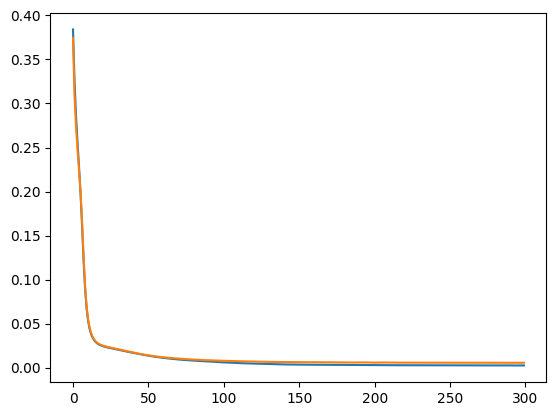

In [120]:
plt.plot(losses)
plt.plot(val_losses)

plt.show()

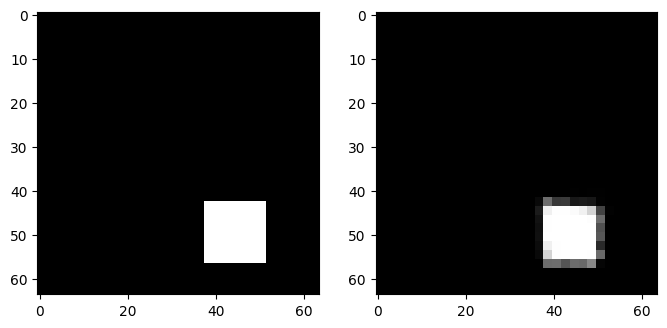

In [127]:
ae_model.eval()
_x = torch.Tensor(X_val[random.randint(0, X_val.shape[0])]).unsqueeze(0)
_x = _x.unsqueeze(1) if grayscale else _x
_recon, latent = ae_model(_x)

img = np.array(_x.squeeze().detach().numpy())
recon_img = _recon.squeeze().detach().numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(img.T, cmap = 'gray' if grayscale else None)
axes[1].imshow(recon_img.T, cmap = 'gray' if grayscale else None)

plt.show()

## Train AE (RGB)

In [138]:
s = 64
grayscale = False

X, y = generate_dataset(n = 3000, size = (s, s), square_size = (3, 16), grayscale = grayscale)
X_val, y_val = generate_dataset(n = 512, size = (s, s), square_size = (3, 16), grayscale = grayscale)

In [139]:
ae_model = Autoencoder(s,
                       data_channels = 1 if grayscale else 3,
                       conv_feature_maps = 24,
                       stride_length = 1,
                       fc_size = 64,
                       latent_size = 24)

conv2d_output_size : 62
pooling_output_size : 31
flatten_size : 23064


In [140]:
ae_criterion = nn.MSELoss()
ae_optimizer = optim.NAdam(ae_model.parameters(), lr = 1e-4)

In [163]:
batch_size = 32
n_train_batches = X.shape[0] // batch_size
n_val_batches = X_val.shape[0] // batch_size
n_epochs = 200
losses = []
val_losses = []

for epoch in range(n_epochs):
    
    ae_model.train()
    for batch_ind in range(n_train_batches):
        
        x = torch.Tensor(X[batch_ind * batch_size: (batch_ind + 1) * batch_size])
        x = x.unsqueeze(1) if grayscale else x
        reconstructed, _ = ae_model(x)
        loss = ae_criterion(reconstructed, x)

        
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
        
    losses.append(loss.item())
    
    ae_model.eval()
    with torch.no_grad():
        val_loss = torch.Tensor([0])
        for batch_ind in range(n_val_batches):
            x = torch.Tensor(X_val[batch_ind * batch_size : (batch_ind + 1) * batch_size])
            x = x.unsqueeze(1) if grayscale else x
            reconstructed, _ = ae_model(x)
            
            val_loss += ae_criterion(reconstructed, x)
            
        
        val_loss = val_loss.item() / n_val_batches
        val_losses.append(val_loss)
        print(f"Epoch : {epoch}/{n_epochs} \t loss = {losses[-1]:.5f} \t val_loss = {val_loss:.5f}")

Epoch : 0/200 	 loss = 0.00116 	 val_loss = 0.00276
Epoch : 1/200 	 loss = 0.00111 	 val_loss = 0.00272
Epoch : 2/200 	 loss = 0.00110 	 val_loss = 0.00277
Epoch : 3/200 	 loss = 0.00110 	 val_loss = 0.00276
Epoch : 4/200 	 loss = 0.00108 	 val_loss = 0.00273
Epoch : 5/200 	 loss = 0.00111 	 val_loss = 0.00272
Epoch : 6/200 	 loss = 0.00109 	 val_loss = 0.00276
Epoch : 7/200 	 loss = 0.00109 	 val_loss = 0.00278
Epoch : 8/200 	 loss = 0.00107 	 val_loss = 0.00274
Epoch : 9/200 	 loss = 0.00110 	 val_loss = 0.00271
Epoch : 10/200 	 loss = 0.00110 	 val_loss = 0.00273
Epoch : 11/200 	 loss = 0.00106 	 val_loss = 0.00275
Epoch : 12/200 	 loss = 0.00105 	 val_loss = 0.00278
Epoch : 13/200 	 loss = 0.00104 	 val_loss = 0.00277
Epoch : 14/200 	 loss = 0.00102 	 val_loss = 0.00270
Epoch : 15/200 	 loss = 0.00104 	 val_loss = 0.00268
Epoch : 16/200 	 loss = 0.00103 	 val_loss = 0.00268
Epoch : 17/200 	 loss = 0.00105 	 val_loss = 0.00272
Epoch : 18/200 	 loss = 0.00104 	 val_loss = 0.00273
Epo

KeyboardInterrupt: 

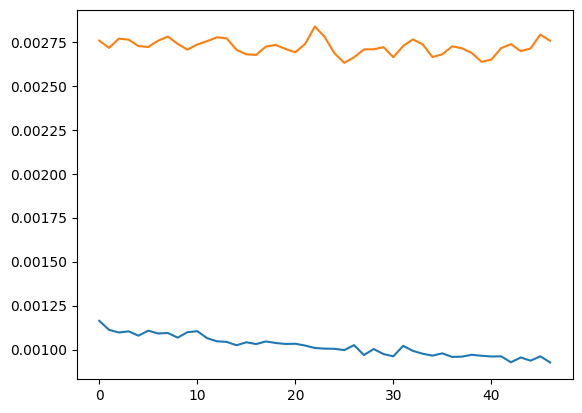

In [164]:
plt.plot(losses)
plt.plot(val_losses)

plt.show()

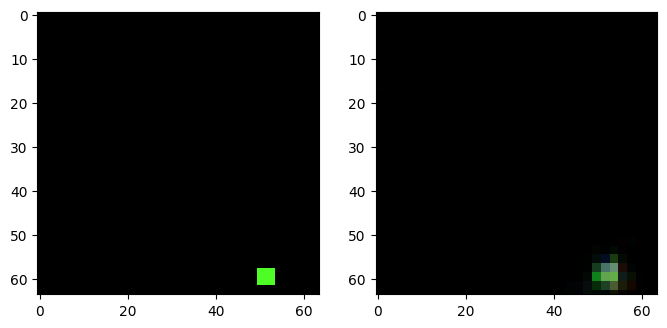

In [167]:
ae_model.eval()
_x = torch.Tensor(X_val[random.randint(0, X_val.shape[0])]).unsqueeze(0)
_x = _x.unsqueeze(1) if grayscale else _x
_recon, latent = ae_model(_x)

img = np.array(_x.squeeze().detach().numpy())
recon_img = _recon.squeeze().detach().numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(img.T, cmap = 'gray' if grayscale else None)
axes[1].imshow(recon_img.T, cmap = 'gray' if grayscale else None)

plt.show()

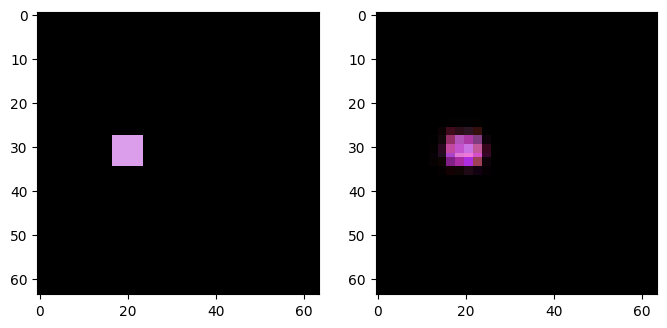

In [174]:
ae_model.eval()
_x = torch.Tensor(generate_datapoint(size=(64, 64), square_size=(3, 16), grayscale=False)[0]).unsqueeze(0)
_x = _x.unsqueeze(1) if grayscale else _x
_recon, latent = ae_model(_x)

img = np.array(_x.squeeze().detach().numpy())
recon_img = _recon.squeeze().detach().numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(img.T, cmap = 'gray' if grayscale else None)
axes[1].imshow(recon_img.T, cmap = 'gray' if grayscale else None)

plt.show()

## Scratch Area

In [153]:
torch.Tensor(X[32:64]).unsqueeze(1).shape

torch.Size([32, 1, 32, 32])

In [198]:
ae_criterion(torch.Tensor(X[0:batch_size]).unsqueeze(1).flatten(), torch.Tensor(X[batch_size:batch_size*2]).unsqueeze(1).flatten())

0.0465235710144043

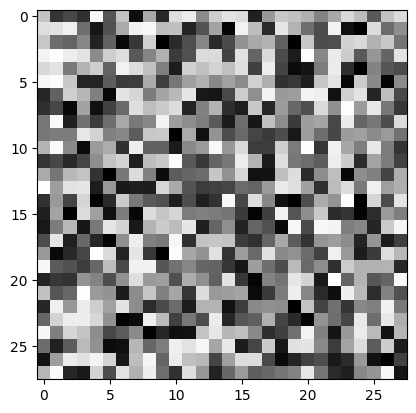

In [85]:
# x = np.ones((28, 28), dtype = np.uint8) * 255
# plt.imshow(x, cmap='gray', vmin=0, vmax=255)


x = np.ones((28, 28)) * np.random.uniform(size = (28, 28)) * 255
plt.imshow(x, cmap = 'gray')